,Model,Accuracy,AUC
1,XGBoost,0.883333,0.883170
0,Logistic Regression,0.873171,0.872971
2,SVM,0.850000,0.849113
3,Neural Network,0.850000,0.849113
4,Transformer,0.800000,0.799327


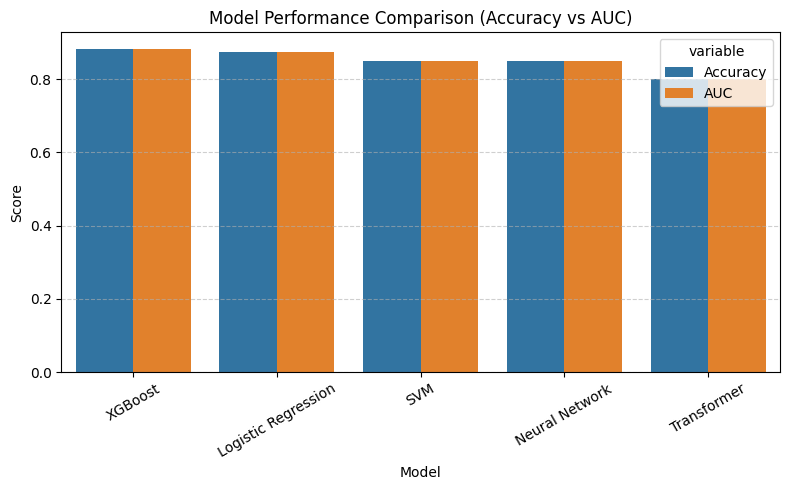


🔍 Plotting ROC Curves...


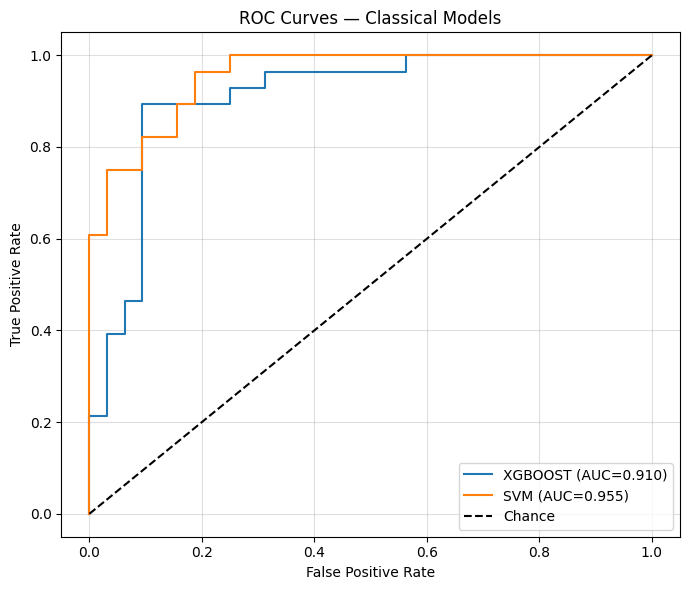

In [1]:
# ===============================================================
# Model Comparison & Visualization
# ===============================================================
# Compares Logistic Regression, XGBoost, SVM, Neural Network, Transformer
# on the Cleveland Heart Disease dataset
# ===============================================================

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# ==== Paths ====
BASE_DIR = os.path.abspath("..") if "notebooks" in os.getcwd() else os.getcwd()
RESULTS_DIR = os.path.join(BASE_DIR, "experiments", "results")
PROCESSED_DIR = os.path.join(BASE_DIR, "data", "processed")

# ==== Collect all model metrics ====
metrics_files = {
    "Logistic Regression": "logistic_regression_metrics.csv",
    "XGBoost": "xgboost_metrics.csv",
    "SVM": "svm_metrics.csv",
    "Neural Network": "neural_network_metrics.csv",
    "Transformer": "transformer_metrics.csv",
}

metrics_summary = []

for model_name, filename in metrics_files.items():
    path = os.path.join(RESULTS_DIR, filename)
    if os.path.exists(path):
        df = pd.read_csv(path, index_col=0)
        acc = df.loc["accuracy", "precision"] if "accuracy" in df.index else np.nan
        auc = df.loc["weighted avg", "f1-score"] if "weighted avg" in df.index else np.nan
        metrics_summary.append({"Model": model_name, "Accuracy": acc, "AUC": auc})
    else:
        metrics_summary.append({"Model": model_name, "Accuracy": np.nan, "AUC": np.nan})

metrics_df = pd.DataFrame(metrics_summary)
metrics_df.sort_values(by="AUC", ascending=False, inplace=True)

display(metrics_df)

# ==== Plot Accuracy vs AUC leaderboard ====
plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df.melt(id_vars="Model"), x="Model", y="value", hue="variable")
plt.title("Model Performance Comparison (Accuracy vs AUC)")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# ==== ROC Curve comparison ====
# Reconstruct ROC curves from saved models if possible
from sklearn.metrics import roc_curve

print("\n🔍 Plotting ROC Curves...")

# Load processed test set
X = joblib.load(os.path.join(PROCESSED_DIR, "cleveland_X.joblib"))
y = joblib.load(os.path.join(PROCESSED_DIR, "cleveland_y.joblib"))
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Helper to safely load and predict
def predict_proba(model_name, loader_fn):
    try:
        model_path = os.path.join(RESULTS_DIR, f"{model_name}_model.joblib")
        model = joblib.load(model_path)
        y_prob = model.predict_proba(X_test)[:, 1]
        return y_prob
    except Exception:
        return None

roc_data = []
for model_name in ["logistic_regression", "xgboost", "svm"]:
    y_prob = predict_proba(model_name, joblib)
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        roc_data.append((model_name, fpr, tpr, auc))

# Plot ROC curves
plt.figure(figsize=(7, 6))
for name, fpr, tpr, auc in roc_data:
    plt.plot(fpr, tpr, label=f"{name.upper()} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Classical Models")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()

# ==== Confusion Matrix Visualization ====
def plot_confusion(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix — {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
